# 0. General

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
import glob
import ipywidgets as widgets
import os

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
from neurokit2.signal import signal_smooth

from src.metrics.disentanglement import Disentanglement
from src.utils.helper import Helper
from src.utils.visualizations import Visualizations

2024-02-08 12:18:44.571541: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-08 12:18:44.593203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 12:18:44.593227: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 12:18:44.594025: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 12:18:44.598413: I tensorflow/core/platform/cpu_feature_guar

In [3]:
os.environ['TFDS_DATA_DIR'] = '/mnt/sdb/home/ml/tensorflow_datasets/'

### Functions

In [4]:
def axis_feature_mapping(df, ld):
    cols = df.columns
    for j in cols[ld:]:
        max_score = 0.0
        dimension = None
        for k in cols[:ld]:
            X = np.array(df.loc[:, k]).reshape(-1, 1)
            y = df.loc[:, j]
            try:
                reg = LinearRegression().fit(X, y)
                score = reg.score(X, y)
                if score > max_score:
                    dimension = k
                    max_score = score
            except:
                continue
                
        print('%20s' % j, '-', dimension, ':', '\t', np.round(max_score, 2))

In [5]:
def experiments(filter='2024-01-31 16:45:22'):
    df = pd.DataFrame()
    for k in glob.glob('../results/*/'):
        params = Helper.load_yaml_file(k + 'params.json')
        try:
            train_progress = pd.read_csv(k + 'training/training_progress.csv')
            n = np.argmin(train_progress.recon)
            train_progress = train_progress.loc[n:n, ['alpha', 'beta', 'gamma', 'loss', 'recon', 'mi', 'tc', 'dw_kl']]
            train_progress['time'] = pd.to_datetime(k[11:-1], format='%Y-%m-%d_%H-%M-%S')
            train_progress['latent_dim'] = params['latent_dimension']
            embedding, ld = Helper.load_embedding(k + 'evaluation/embedding/', 'synth', 'train')
            mus_train = np.array(embedding.iloc[:, :ld])
            ys_train = np.array(embedding.loc[:, ['t_height', 'p_height']])
            train_progress['dataset'] = 'synth'
            train_progress['MIG'] = Disentanglement.compute_mig(mus_train, ys_train)['discrete_mig']
            df = pd.concat([df, train_progress])
        except Exception as e:
            print('failed on:', k)
    df.reset_index(inplace=True, drop=True)
    df = df[(df.time > filter)].sort_values('time').reset_index(drop=True)
    return df

In [6]:
def select_path():
    return widgets.Dropdown(
        options=sorted(glob.glob('../results/*')),
        description='Base path:',
        disabled=False,
    )

In [7]:
def reconstruct(dim, x):
    embedding = np.mean(df_synth.iloc[:,:ld], axis=0)
    embedding[dim] = x
    embedding = np.reshape(embedding, (1, ld))
    decoded = signal_smooth(np.reshape(model.decode(embedding), 500))
    plt.figure(figsize=(15,5))
    plt.plot(decoded)

In [8]:
def print_metrics_binary(cm):
    print('Accuracy:   \t', np.trace(cm) / np.sum(cm), '\n')
    print('Sensitivity:\t', cm[0,0] / (cm[0,0] + cm[1,0]), '\n')
    print('Specificity:\t', cm[1,1] / (cm[1,1] + cm[0,1]), '\n')

In [9]:
def print_metrics_multiclass(cm):
    print('Accuracy:   \t', np.trace(cm) / np.sum(cm), '\n')

### Experiments

In [10]:
#df = experiments()

In [11]:
#df = df.sort_values('MIG', ascending=False).round(2)

In [12]:
#df.head(10)

In [13]:
'''df.sort_values(
    'time'
)[[
    'alpha', 'beta', 'gamma', 'latent_dim', 'loss', 'recon', 'mi', 'tc', 'dw_kl', 'MIG'
]].to_latex(
    index=False
).replace(
    '\n', ''
).replace(
    '.000000', ''
).replace(
    '0000', ''
)'''

"df.sort_values(\n    'time'\n)[[\n    'alpha', 'beta', 'gamma', 'latent_dim', 'loss', 'recon', 'mi', 'tc', 'dw_kl', 'MIG'\n]].to_latex(\n    index=False\n).replace(\n    '\n', ''\n).replace(\n    '.000000', ''\n).replace(\n    '0000', ''\n)"

### Path Selection

In [14]:
val = select_path()

In [15]:
val

Dropdown(description='Base path:', options=('../results/2024-01-28_15-51-16', '../results/2024-01-28_21-12-28'…

In [17]:
path_base = val.value + '/'
path_embedding = path_base + 'evaluation/embedding/'
path_personalization = path_base + 'evaluation/personalization/'
path_training = path_base + 'training/'
model = tf.keras.models.load_model(path_base + 'model/')

2024-02-08 12:26:40.399361: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-08 12:26:40.399540: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-08 12:26:40.399645: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [22]:
ld=8

In [23]:
widgets.interact(reconstruct, dim=range(0, ld), x=(-5.0, 5.0, 0.5))

interactive(children=(Dropdown(description='dim', options=(0, 1, 2, 3, 4, 5, 6, 7), value=0), FloatSlider(valu…

<function __main__.reconstruct(dim, x)>

### General

In [18]:
params = Helper.load_yaml_file(path_base + 'params.json')

In [19]:
train_progress = pd.read_csv(path_training + 'training_progress.csv')

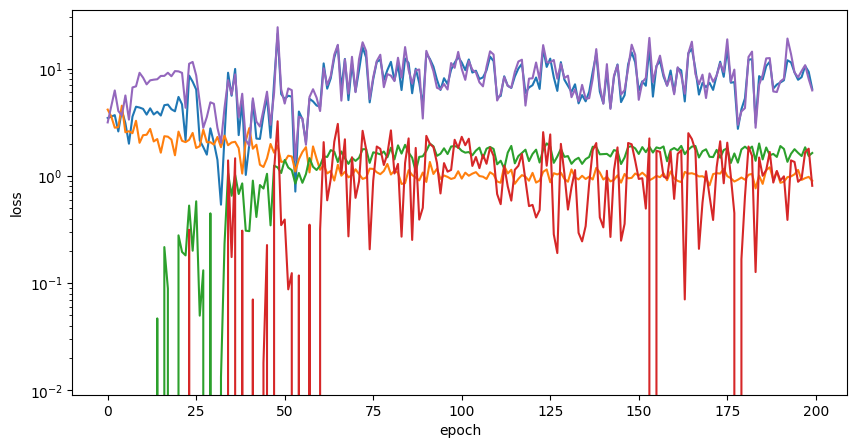

In [20]:
Visualizations.plot_trainings_process(train_progress[0:], ['loss', 'recon', 'mi', 'tc', 'dw_kl'])

In [19]:
df_synth, ld = Helper.load_embedding(path_embedding, 'synth', 'train')
df_zheng, _ = Helper.load_embedding(path_embedding, 'zheng', 'train')
df_medalcare_train, _ = Helper.load_embedding(path_embedding, 'medalcare', 'train')
df_medalcare_validation, _ = Helper.load_embedding(path_embedding, 'medalcare', 'validation')
df_medalcare_test, _ = Helper.load_embedding(path_embedding, 'medalcare', 'test')
df_ptb, _ = Helper.load_embedding(path_embedding, 'ptb', 'train')

FileNotFoundError: [Errno 2] No such file or directory: '../results/2024-01-28_15-51-16/evaluation/embedding/medalcare/train/medalcare_train_data.npy'

In [22]:
'''
df_medalcare_train.diad = df_medalcare_train.diagnosis.replace(
    0.0, 'avblock'
).replace(
    1.0, 'fam'
).replace(
    2.0, 'iab'
).replace(
    3.0, 'lae'
).replace(
    4.0, 'lbbb'
).replace(
    5.0, 'mi'
).replace(
    6.0, 'rbbb'
).replace(
    7.0, 'sinus'
)
'''

"\ndf_medalcare_train.diad = df_medalcare_train.diagnosis.replace(\n    0.0, 'avblock'\n).replace(\n    1.0, 'fam'\n).replace(\n    2.0, 'iab'\n).replace(\n    3.0, 'lae'\n).replace(\n    4.0, 'lbbb'\n).replace(\n    5.0, 'mi'\n).replace(\n    6.0, 'rbbb'\n).replace(\n    7.0, 'sinus'\n)\n"

# 1. Disentanglement

In [23]:
axis_feature_mapping(df_synth, ld)

             r_width - 17 : 	 0.23
            q_height - 23 : 	 0.0
             q_width - 23 : 	 0.21
             t_width - 6 : 	 0.05
                   N - 0 : 	 1.0
             r_angle - 16 : 	 0.0
               hrstd - 0 : 	 1.0
             p_angle - 22 : 	 0.02
              hrmean - 0 : 	 1.0
             p_width - 15 : 	 0.6
             s_angle - 2 : 	 0.0
            p_height - 5 : 	 0.13
              anoise - None : 	 0.0
            r_height - 6 : 	 0.05
             s_width - 12 : 	 0.35
             q_angle - 14 : 	 0.01
            t_height - 20 : 	 0.26
               sfint - 0 : 	 1.0
            s_height - 12 : 	 0.03
             t_angle - 6 : 	 0.01
              s_fecg - 0 : 	 1.0
           lfhfratio - 0 : 	 1.0


In [24]:
axis_feature_mapping(df_zheng, ld)

    ventricular_rate - 18 : 	 0.16
         qt_interval - 18 : 	 0.05
        qt_corrected - 15 : 	 0.01
              t_axis - 6 : 	 0.04
              r_axis - 20 : 	 0.02
            q_offset - 23 : 	 0.01
              gender - 15 : 	 0.01
        qrs_duration - 17 : 	 0.04
             subject - 14 : 	 0.01
                 age - 15 : 	 0.11
              rhythm - 18 : 	 0.07
           qrs_count - 18 : 	 0.16
         atrial_rate - 18 : 	 0.09
            t_offset - 18 : 	 0.11
             q_onset - 17 : 	 0.02
                beat - 9 : 	 0.05


In [25]:
axis_feature_mapping(df_ptb, ld)

              gender - 23 : 	 0.0
                 age - 15 : 	 0.13
             subject - 15 : 	 0.01
          diagnostic - 20 : 	 0.09


In [26]:
axis_feature_mapping(df_medalcare_train, ld)

           v_G.blood - None : 	 0.0
a_ar.CristaTerminalis - 23 : 	 0.02
      v_stim[3].time - 0 : 	 0.08
       v_stim[4].thr - 23 : 	 0.08
              v_G.el - None : 	 0.0
            v_V3.phi - 0 : 	 0.15
              v_G.en - None : 	 0.0
              v_V1.z - 0 : 	 0.06
a_ar.PectinateMuscles - None : 	 0.0
            v_V5.phi - 0 : 	 0.13
     v_cv.rvendo_s_r - 0 : 	 1.0
       v_stim[4].rho - 0 : 	 0.14
       v_stim[2].phi - 0 : 	 0.07
              v_V2.z - 0 : 	 0.23
            v_V6.rho - 0 : 	 0.03
              v_V5.z - 0 : 	 0.2
           v_APD.min - 17 : 	 0.0
   a_cv_t.BulkTissue - 23 : 	 0.02
             subject - 17 : 	 0.0
      v_stim[2].time - 0 : 	 0.08
a_ar.InferiorIsthmus - 0 : 	 1.0
              v_G.et - None : 	 0.0
       v_stim[0].rho - 0 : 	 0.15
           v_G.lungs - None : 	 0.0
   v_stim[0].rho_eps - 0 : 	 0.15
       v_stim[1].phi - 8 : 	 0.0
              v_G.il - None : 	 0.0
     v_cv.rvendo_n_r - 0 : 	 1.0
  v_fibers.alpha_epi - 0 : 	 1.0
a

In [27]:
df_synth.p_height = df_synth.p_height.round()
df_synth.t_height = df_synth.t_height.round()

/mnt/sdb/home/ml/Desktop/VECG/src/utils/visualizations.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


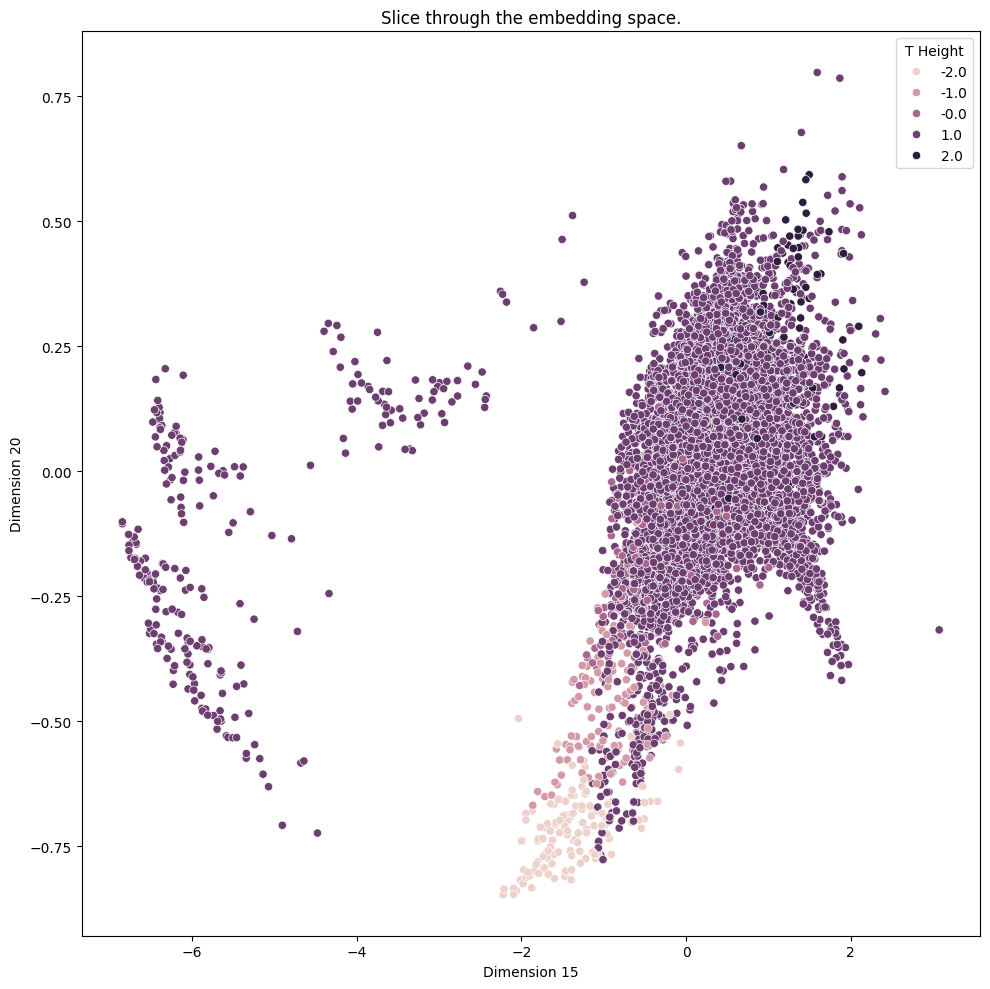

In [29]:
Visualizations.plot_embedding_slice(df_synth, 15, 20, 't_height', 'T Height', '../media/embedding_synth_theight.png')

/mnt/sdb/home/ml/Desktop/VECG/src/utils/visualizations.py:124: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


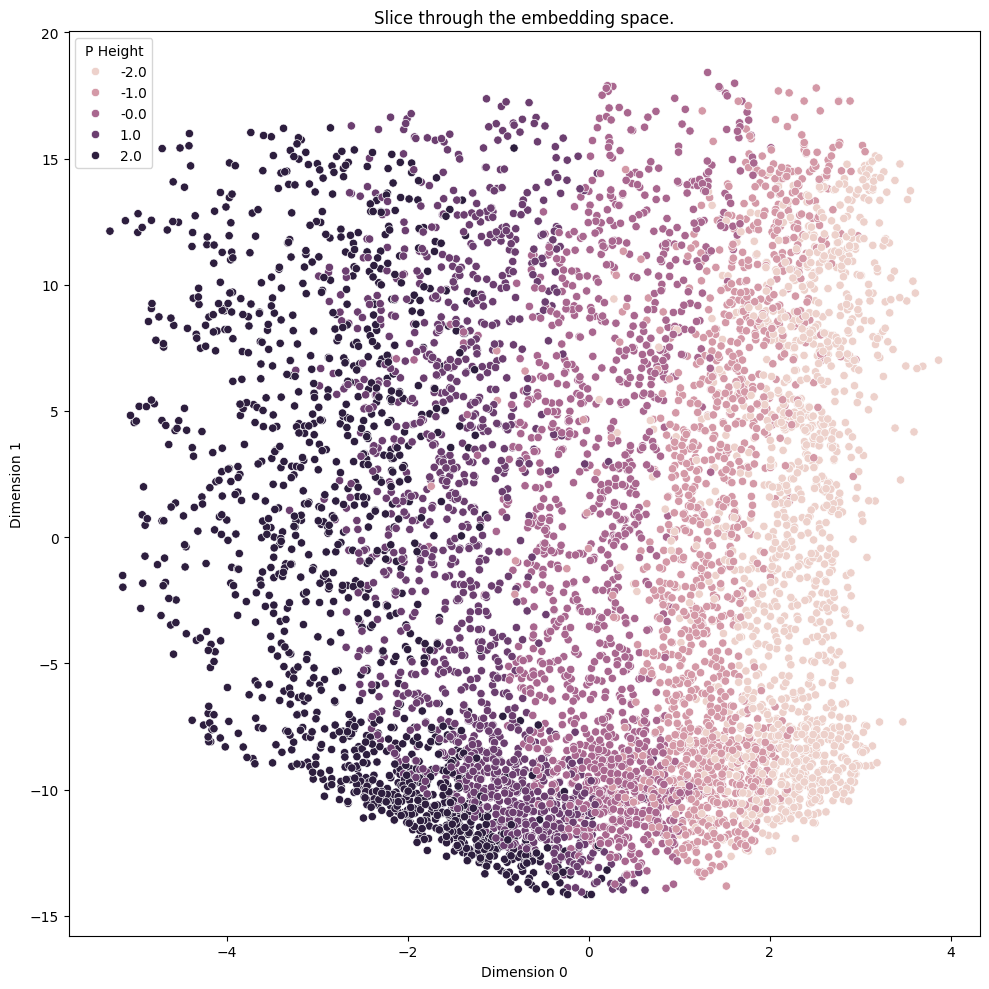

In [30]:
Visualizations.plot_embedding_slice(df_synth, 0, 1, 'p_height', 'P Height', '../media/embedding_synth_pheight.png')

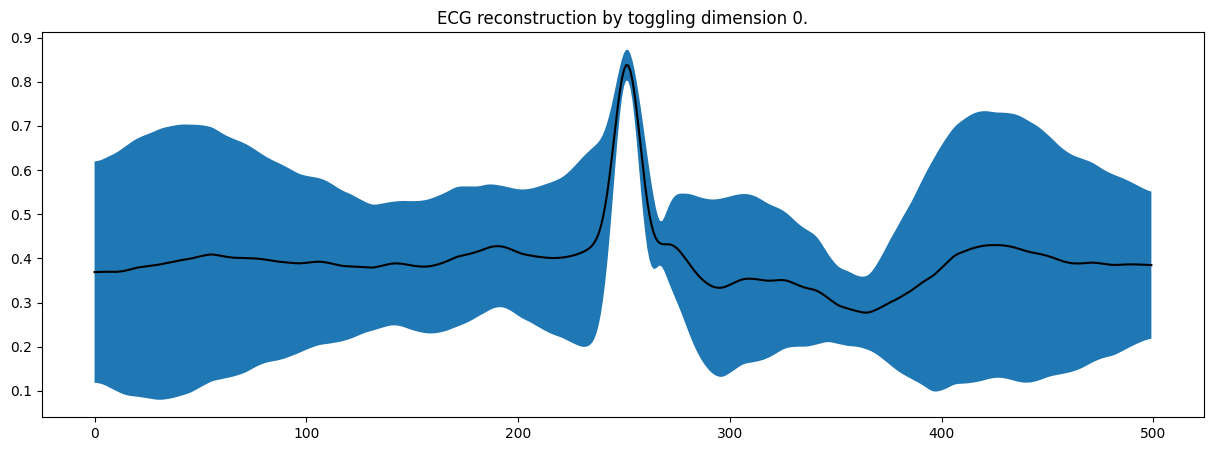

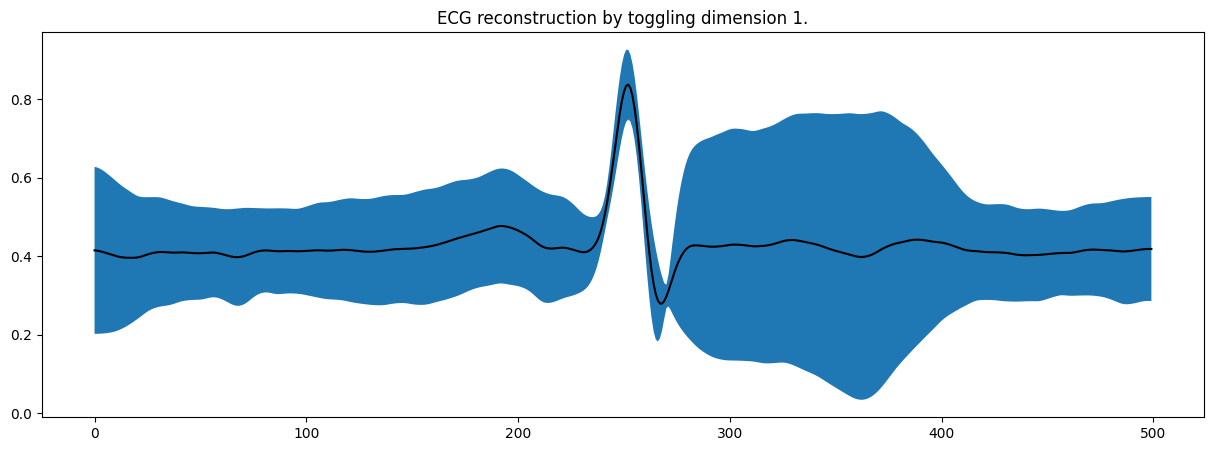

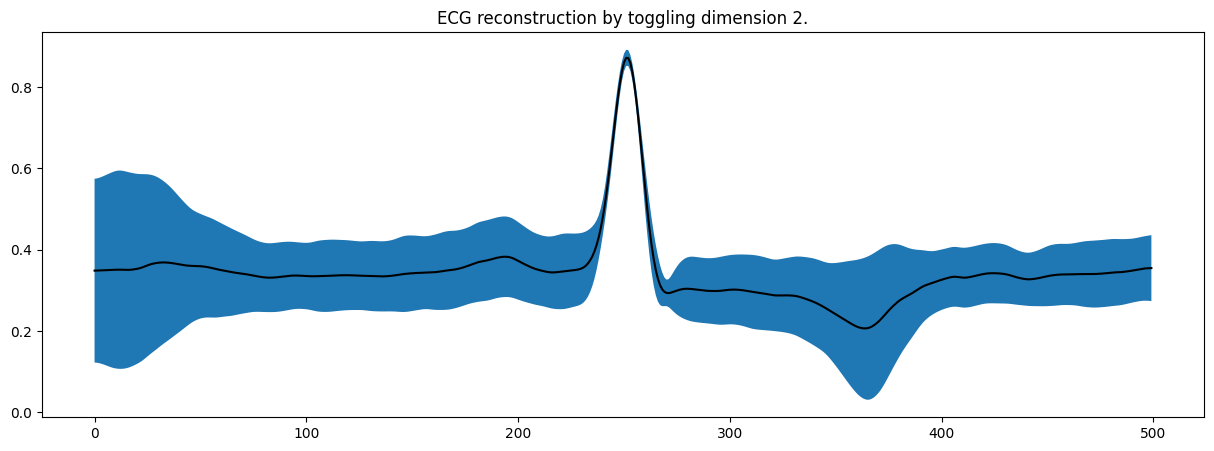

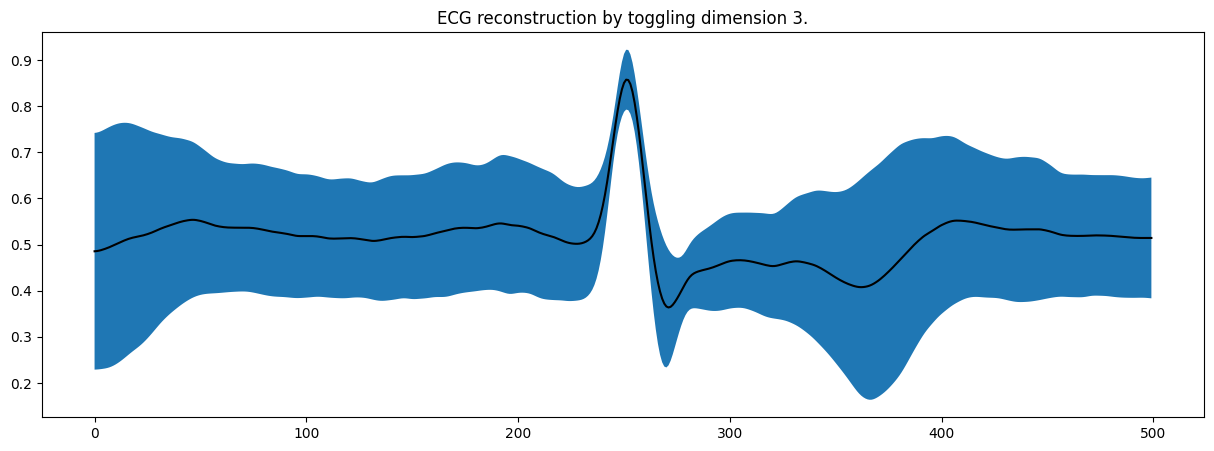

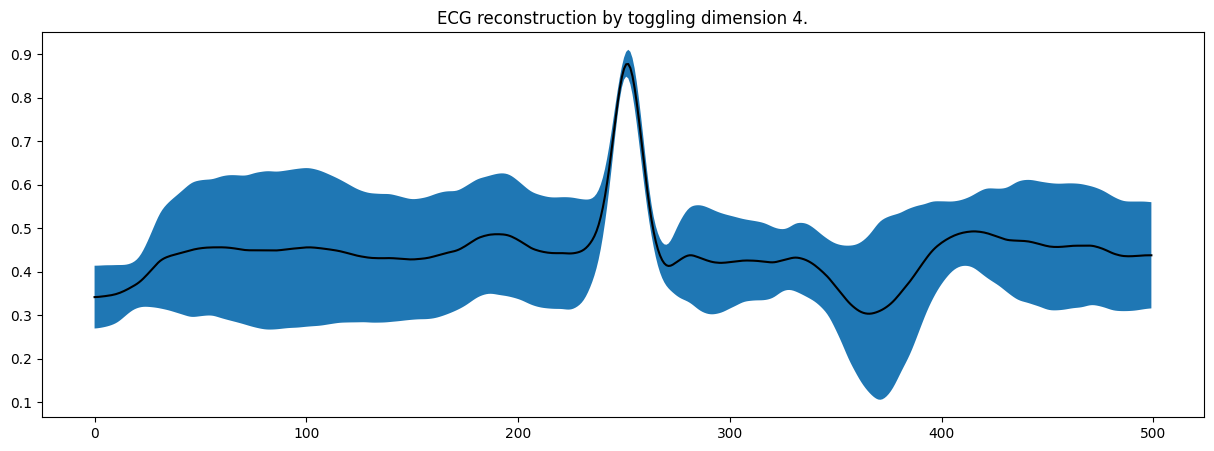

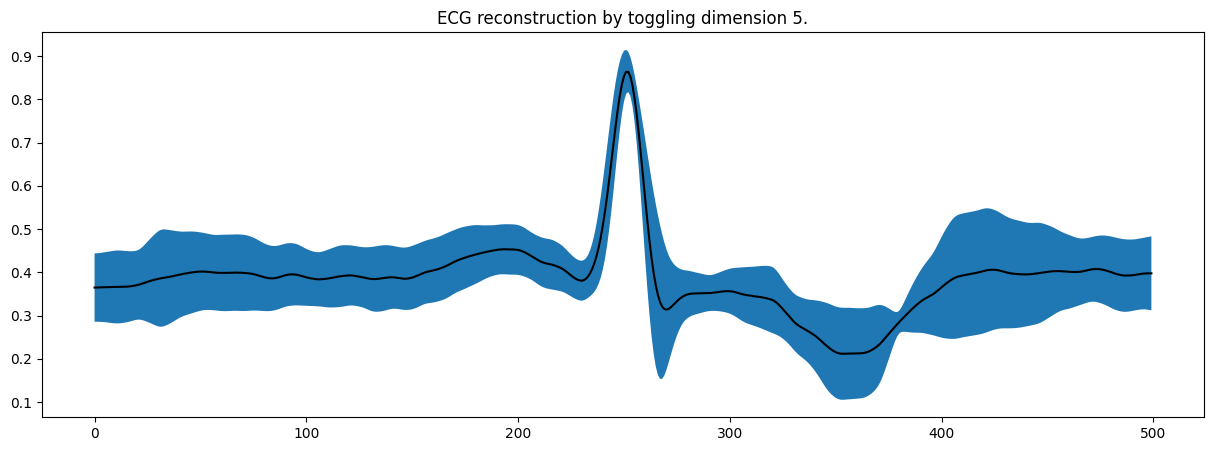

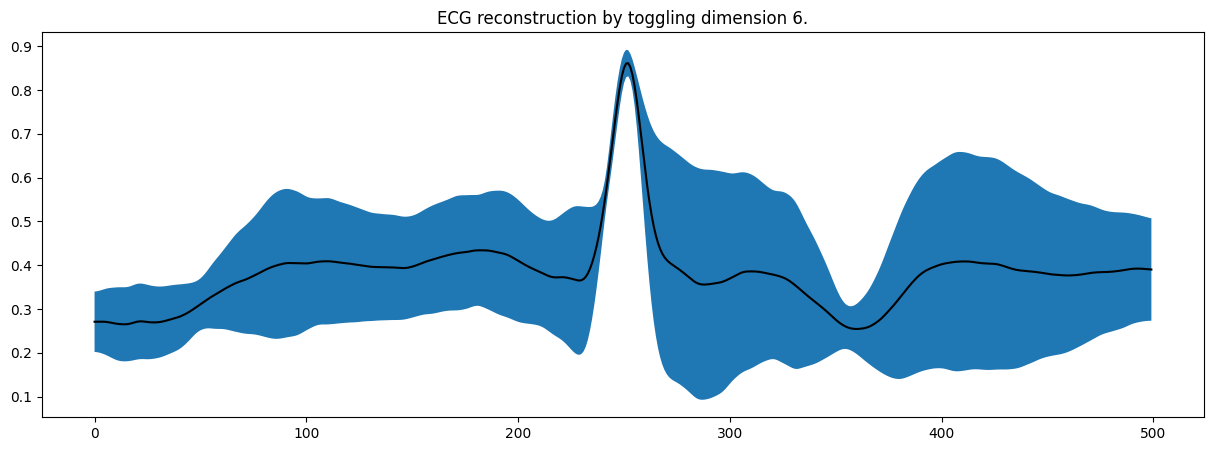

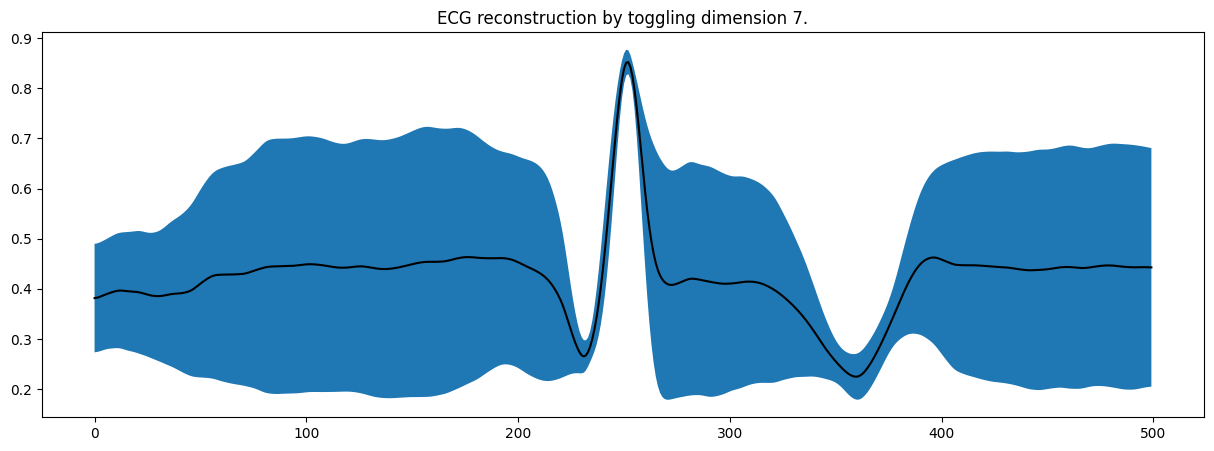

In [24]:
for k in range(0, ld):
    Visualizations.eval_dimensions(ld, model, k, '../media/reconstruction_synth_' + str (k) + '.png')

interactive(children=(Dropdown(description='dim', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.reconstruct(dim, x)>

In [31]:
data, size_data = Helper.load_multiple_datasets(
    {
        'name': ['synth'],
        'split': 'train', 'shuffle_size': 1024, 'batch_size': 1024},
)

In [32]:
for k in Helper.data_generator(data, method='stop'):
    continue

In [33]:
data_predict = model.predict(k)

1/1 [==============================] - 0s 414ms/step


In [38]:
n = 3

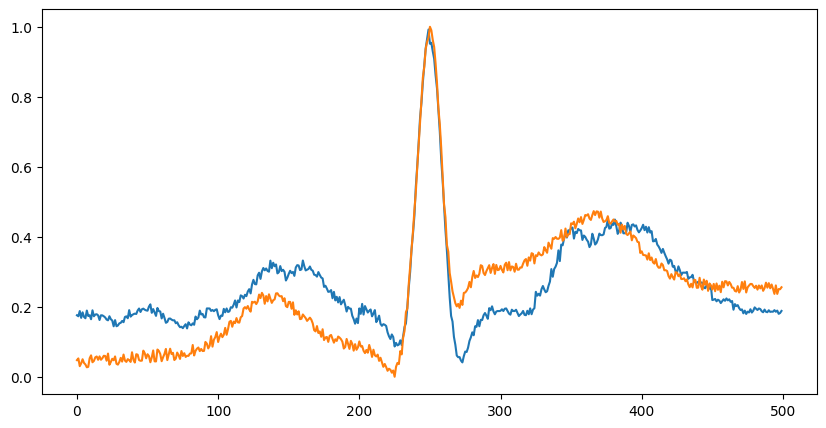

In [39]:
plt.figure(figsize=(10,5))
plt.plot(data_predict[n])
plt.plot(k[n])

# 2. Anomaly Detection

## CU-SPH

In [62]:
df_zheng = df_zheng.fillna(0.0)

In [63]:
a = ['SB', 'SR', 'AFIB', 'ST', 'AF', 'SI', 'SVT', 'AT', 'AVNRT', 'AVRT', 'SAAWR', 'SA']
b = ['Anomaly', 'Healthy', 'Anomaly', 'Anomaly', 'Anomaly', 'Anomaly', 'Anomaly', 'Anomaly', 'Anomaly',
     'Anomaly', 'Anomaly', 'Anomaly']
df_zheng['rhythm_binary'] = df_zheng.rhythm
for k in range(0, len(a)):
    df_zheng.rhythm = df_zheng.rhythm.replace(float(k), a[k])
    df_zheng.rhythm_binary = df_zheng.rhythm_binary.replace(float(k), b[k])

In [64]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    df_zheng.iloc[:, 0:ld],
    df_zheng['rhythm_binary'],
    test_size=0.25,
    random_state=42,
    stratify=df_zheng['rhythm_binary'],
)

X_train, X_test, y_train, y_test = train_test_split(
    df_zheng.iloc[:, 0:ld],
    df_zheng['rhythm'],
    test_size=0.25,
    random_state=42,
    stratify=df_zheng['rhythm'],
)

<Figure size 1500x1500 with 0 Axes>

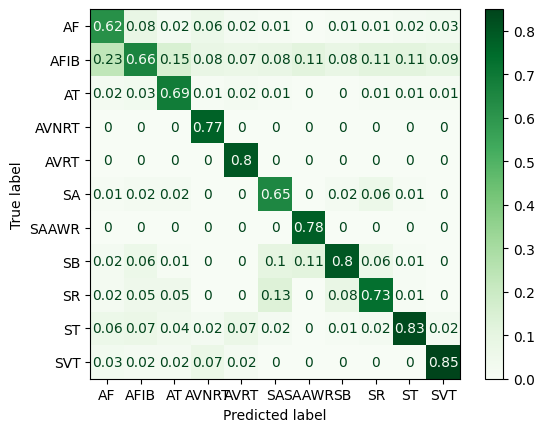

In [65]:
cm = Visualizations.plot_confustion_matrix(
    X_train, X_test, y_train, y_test,
    KNeighborsClassifier(n_neighbors=8), '../media/confusion_matrix_multiclass_zheng_rhyhtm.png',
)

<Figure size 1500x1500 with 0 Axes>

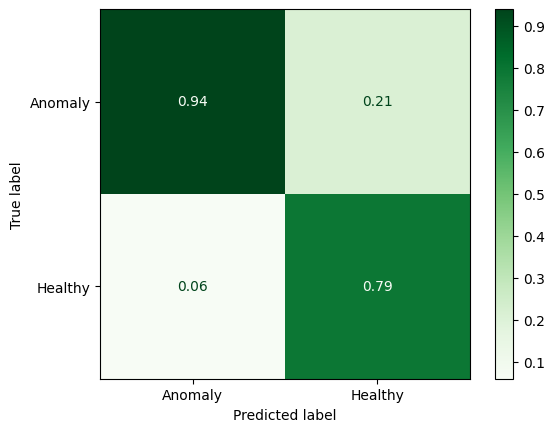

In [66]:
cm_b = Visualizations.plot_confustion_matrix(
    X_train_b, X_test_b, y_train_b, y_test_b,
    KNeighborsClassifier(n_neighbors=8), '../media/confusion_matrix_binary_zheng_rhyhtm.png',
)

In [67]:
print_metrics_binary(cm_b)

Accuracy:   	 0.922077922077922 

Sensitivity:	 0.9439659718072204 

Specificity:	 0.7863061491495857 


In [68]:
print_metrics_multiclass(cm)

Accuracy:   	 0.7640541276904913 


## PTB

In [69]:
a = ['STTC', 'NORM', 'MI', 'HYP', 'CD', 'NAV']
b = ['Anomaly', 'Healthy', 'Anomaly', 'Anomaly', 'Anomaly', 'Anomaly']
df_ptb['diagnostic_binary'] = df_ptb.diagnostic
for k in range(0, len(a)):
    df_ptb.diagnostic = df_ptb.diagnostic.replace(float(k), a[k])
    df_ptb.diagnostic_binary = df_ptb.diagnostic_binary.replace(float(k), b[k])

In [114]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(
    df_ptb.iloc[:, 0:ld],
    df_ptb['diagnostic_binary'],
    test_size=0.25,
    random_state=42,
    stratify=df_ptb['diagnostic_binary'],
)

X_train, X_test, y_train, y_test = train_test_split(
    df_ptb.iloc[:, 0:ld],
    df_ptb['diagnostic'],
    test_size=0.25,
    random_state=42,
    stratify=df_ptb['diagnostic'],
)

KeyError: 'diagnostic_binary'

<Figure size 1500x1500 with 0 Axes>

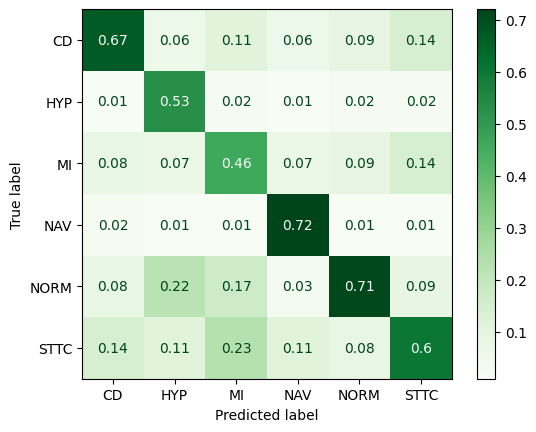

In [71]:
cm = Visualizations.plot_confustion_matrix(
    X_train, X_test, y_train, y_test,
    KNeighborsClassifier(n_neighbors=10), '../media/confusion_matrix_multiclass_ptb_diagnostic.png',
)

<Figure size 1500x1500 with 0 Axes>

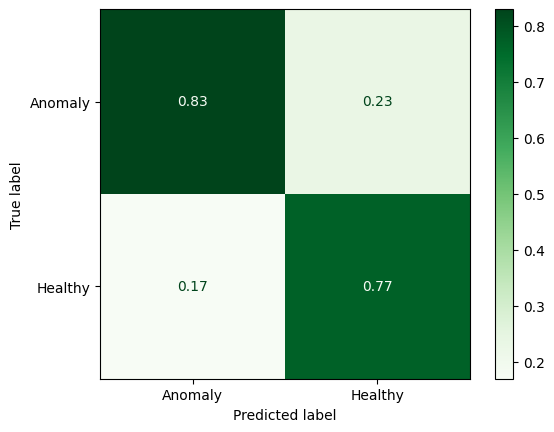

In [72]:
cm_b = Visualizations.plot_confustion_matrix(
    X_train_b, X_test_b, y_train_b, y_test_b,
    KNeighborsClassifier(n_neighbors=8), '../media/confusion_matrix_binary_ptb_diagnostic.png',
)

In [73]:
print_metrics_binary(cm_b)

Accuracy:   	 0.8070781893004115 

Sensitivity:	 0.8296884071995355 

Specificity:	 0.7738090395020545 


In [74]:
print_metrics_multiclass(cm)

Accuracy:   	 0.6609876543209876 


In [115]:
#temp = pd.get_dummies(df_ptb.diagnostic)
#for k in temp:
#    df_ptb[k] = temp[k].replace(False, 0).replace(True, 1)
#df_ptb = df_ptb.drop(['age', 'gender', 'diagnostic', 'diagnostic_binary'], axis=1)

## Medalcare

In [101]:
df_medalcare_train.diagnosis = df_medalcare_train.diagnosis.replace(
    0.0, 'avblock'
).replace(
    1.0, 'fam'
).replace(
    2.0, 'iab'
).replace(
    3.0, 'lae'
).replace(
    4.0, 'lbbb'
).replace(
    5.0, 'mi'
).replace(
    6.0, 'rbbb'
).replace(
    7.0, 'sinus'
)

df_medalcare_test.diagnosis = df_medalcare_test.diagnosis.replace(
    0.0, 'avblock'
).replace(
    1.0, 'fam'
).replace(
    2.0, 'iab'
).replace(
    3.0, 'lae'
).replace(
    4.0, 'lbbb'
).replace(
    5.0, 'mi'
).replace(
    6.0, 'rbbb'
).replace(
    7.0, 'sinus'
)

In [102]:
df_medalcare_train['diagnosis_binary'] = df_medalcare_train.diagnosis != 'sinus'
df_medalcare_test['diagnosis_binary'] = df_medalcare_test.diagnosis != 'sinus'

In [103]:
#temp = pd.get_dummies(df_medalcare_train.diagnosis)
#for k in temp:
#    df[k] = temp[k].replace(False, 0.0).replace(True, 1.0)

In [104]:
#df_medalcare_train.drop('diagnosis', axis=1, inplace=True)

In [105]:
X_train, X_test, y_train, y_test = df_medalcare_train.iloc[:, 0:ld], df_medalcare_test.iloc[:, 0:ld], df_medalcare_train['diagnosis'], df_medalcare_test['diagnosis']

X_train_b, X_test_b, y_train_b, y_test_b = df_medalcare_train.iloc[:, 0:ld], df_medalcare_test.iloc[:, 0:ld], df_medalcare_train['diagnosis_binary'], df_medalcare_test['diagnosis_binary']

<Figure size 1500x1500 with 0 Axes>

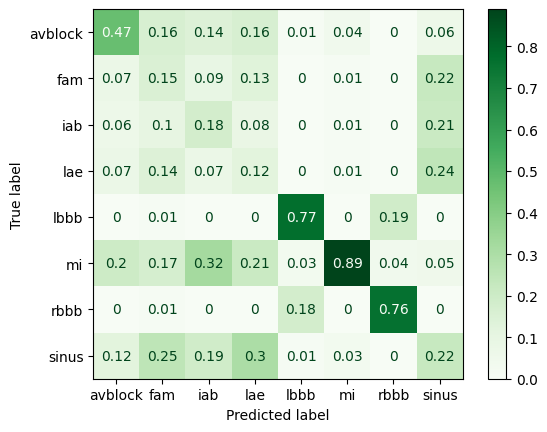

In [113]:
cm = Visualizations.plot_confustion_matrix(
    X_train, X_test, y_train, y_test,
    KNeighborsClassifier(n_neighbors=25), '../media/confusion_matrix_multiclass_medalcare_diagnostic.png',
)

<Figure size 1500x1500 with 0 Axes>

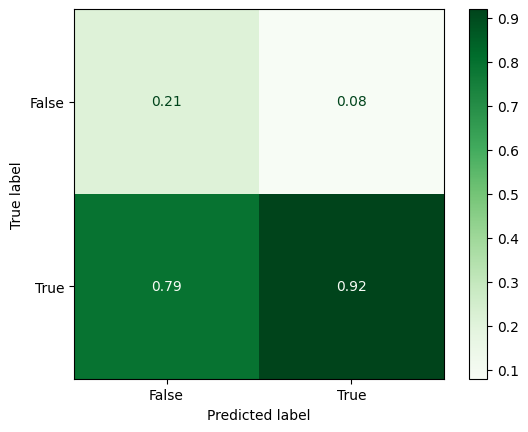

In [108]:
cm_b = Visualizations.plot_confustion_matrix(
    X_train_b, X_test_b, y_train_b, y_test_b,
    KNeighborsClassifier(n_neighbors=20), '../media/confusion_matrix_multiclass_medalcare_diagnostic.png',
)

In [109]:
print_metrics_binary(cm_b)

Accuracy:   	 0.8794157102399761 

Sensitivity:	 0.21178027796161483 

Specificity:	 0.9192497532082922 


In [107]:
print_metrics_multiclass(cm)

Accuracy:   	 0.6409300939037115 


# 3. Personalization

In [ ]:
for k in  glob.glob(path_personalization + 'icentia11k/*'):
    try:
        df, ld = Helper.load_embedding(path_personalization, 'icentia11k', k[69:])
    except:
        print(k[69:], 'not available yet')
        continue
    df.beat = df.beat.replace(0.0, 'Normal').replace(1.0, 'Unclassified').replace(2.0, 'PAC').replace(3.0, 'PVC')
    X = df[df.beat != 'Unclassified'].iloc[:, 0:ld]
    y = df[df.beat != 'Unclassified']['beat']
    
    unique_values, counts = np.unique(y, return_counts=True)
    values_to_keep = unique_values[counts > 1]
    index = np.isin(y, values_to_keep)
    y = y[index]
    X = X[index]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=42,
        stratify=y,
    )
    neigh = KNeighborsClassifier(n_neighbors=20)
    neigh.fit(np.array(X_train), y_train)
    predictions = neigh.predict(X_test)
    cm = confusion_matrix(y_test, predictions, labels=neigh.classes_)
    print(cm)
    print('Accuracy:', np.trace(cm) / np.sum(cm))